训练集大小: 5737, 测试集大小: 2459
测试集中高二元变量分布: (2459, 43) (2459, 1)
Counter({0: 1625, 1: 834})
训练集中高二元变量分布: (5737, 43) (5737, 1)
Counter({0: 3836, 1: 1901})
开始训练LightGBM模型。。。
[LightGBM] [Info] Number of positive: 1901, number of negative: 3836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 5737, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331358 -> initscore=-0.702050
[LightGBM] [Info] Start training from score -0.702050


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


特征重要性:
[ 90 149  40  94  15 128 132  24  98  89  55   9  40   8  42  58 131  69
  74  77  91  35  24  47   0  29  41  32   0  69 130  54  72  69  77  60
  77  92  80  97 105 121 176]
排列索引:
[36  8 34 16 21 10 38 25 12  6 23 11 27  0 22 13  3 31 28 24  5 35 37 30
 39  9 33 14  4 32  7 29 26 41  1 19 40  2 15 42 17 20 18]
SHAP值:
[[ 0.05530977  0.13807773  0.14607286 ... -0.19827188 -0.21200475
   0.11033707]
 [-0.11444971  0.1379301   0.10096448 ... -0.25707104  0.01258706
   0.14815013]
 [ 0.04516138  0.29477132  0.06955604 ...  0.43899937  0.11404836
   0.22242196]
 ...
 [ 0.00508717 -0.05539699  0.13621197 ... -0.288867    0.25067706
  -0.3082596 ]
 [ 0.04854732  0.14795269  0.11801932 ...  0.38875387 -0.18361538
   0.1883136 ]
 [ 0.05797248 -0.1170827   0.17028849 ...  0.28930897  0.02282908
   0.25805891]]
重要特征:
['GAD' 'CDRISC' 'PHQ' 'WF' 'title' 'gender' 'TSB' 'UCLA' 'CITY' 'EC']
重要特征索引:
[18 20 17 42 15  2 40 19  1 41]
Accuracy: 0.7405, Precision: 0.6526, Recall: 0.5024, F1-score: 0

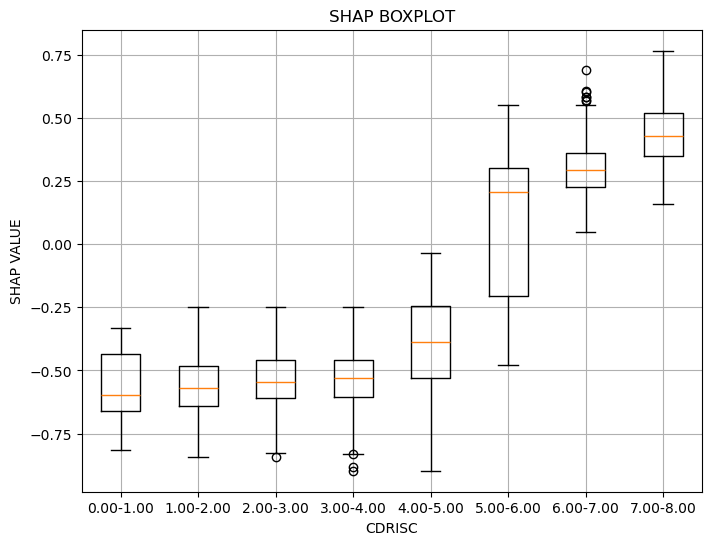

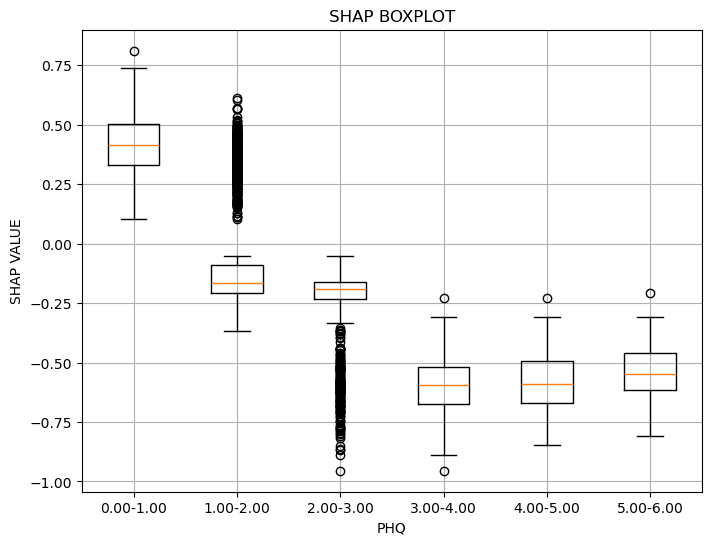

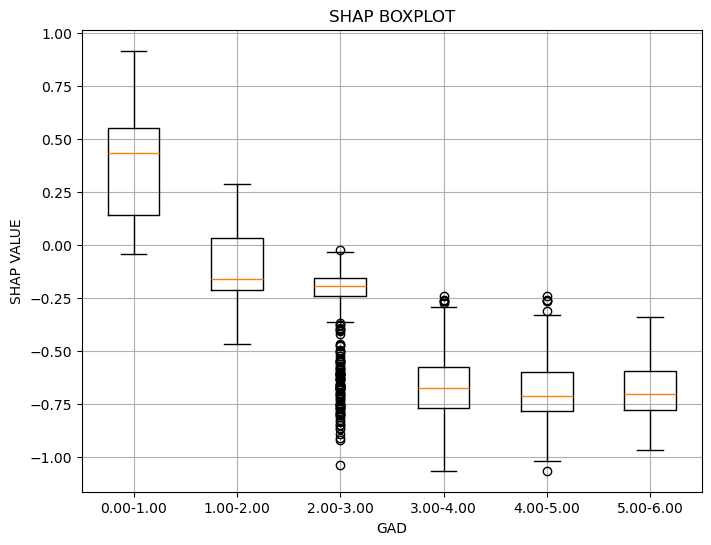

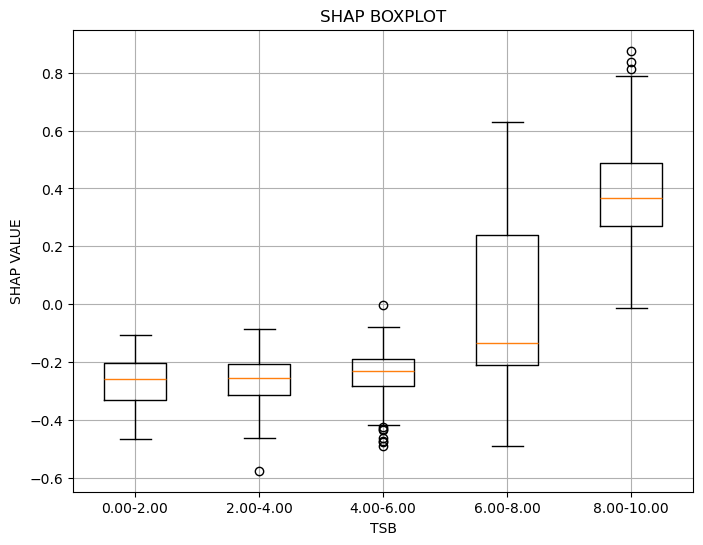

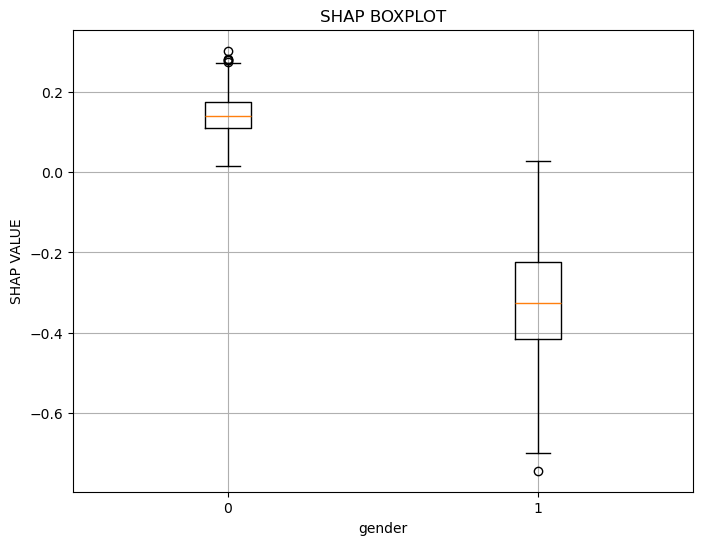

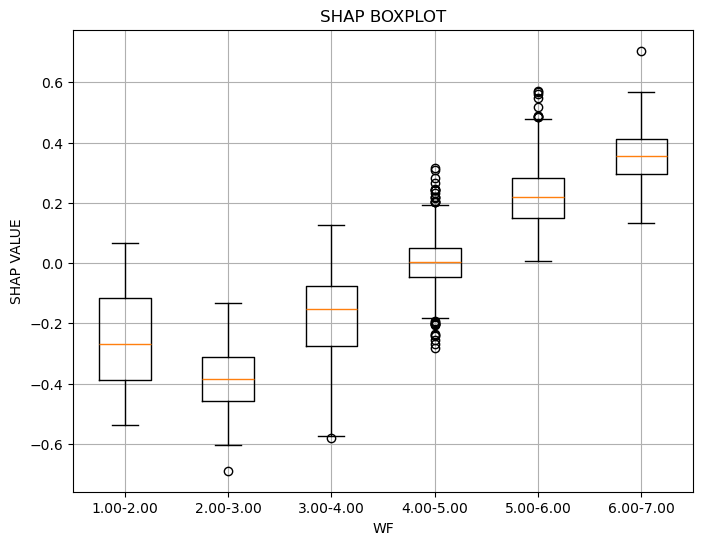

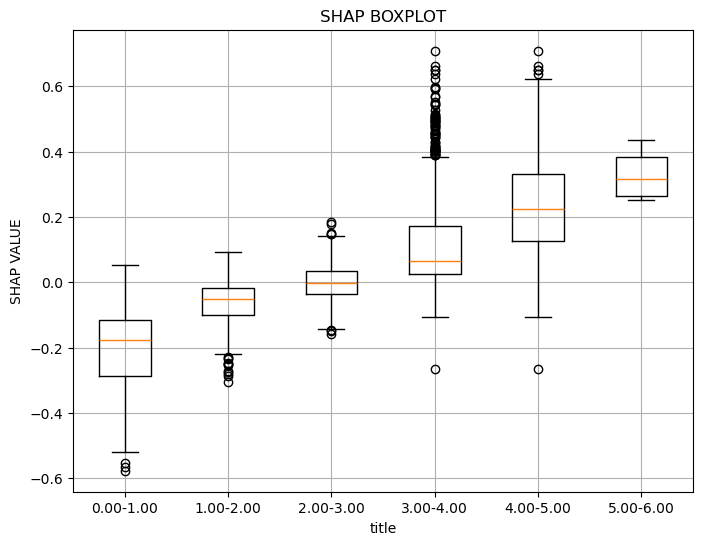

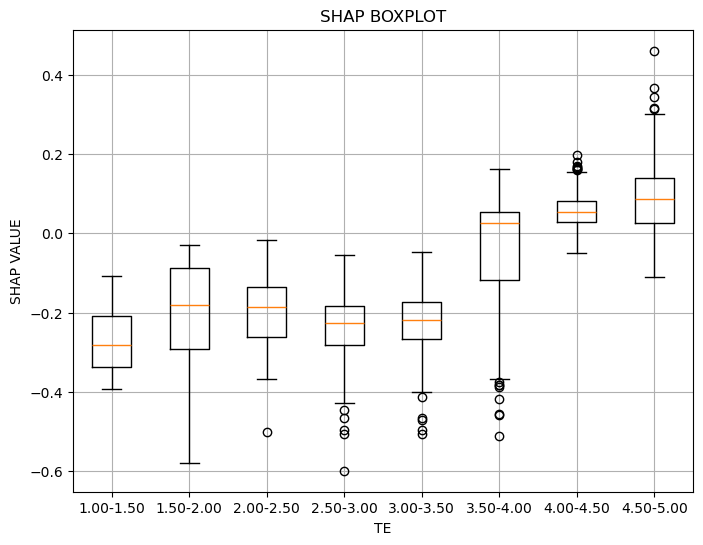

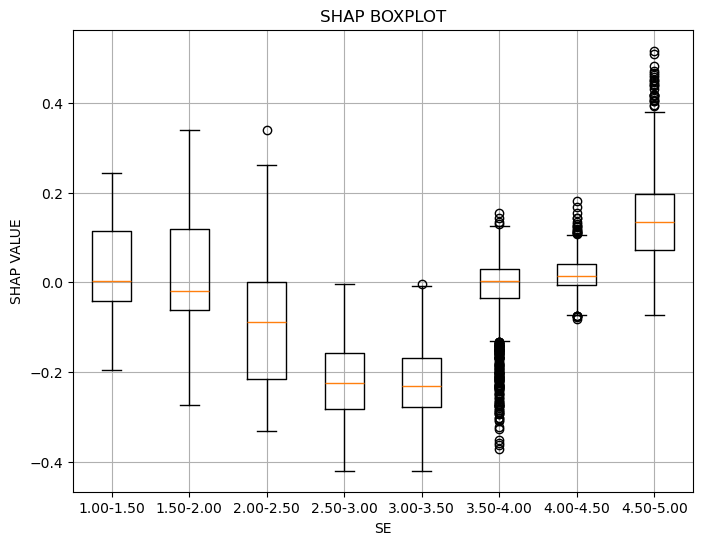

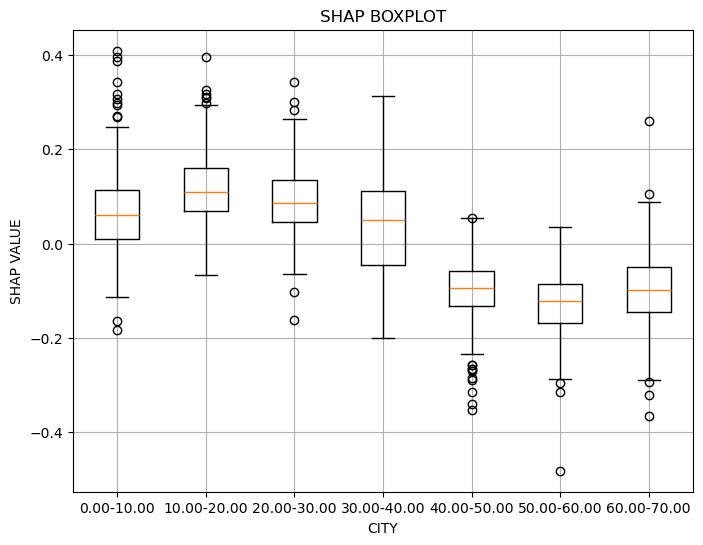

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb

def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['high_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['high_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shap_values, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shap_values)
    print('重要特征:')
    print(top_features)
    print('重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shap_values, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

# 导入数据
df_path = r"C:\Users\29688\Desktop\T1教师_处理后.xlsx"
save_folder = r'C:\Users\29688\Desktop\study-2\pictures\high'  # 替换为你的保存路径
df = pd.read_excel(df_path)
top_n = 10

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu', 'height', 'weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan', 'BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work', 'mediation', 'mediationd',
             'sport', 'walk', 'sportd', 'walkd', 'TE', 'subject', 'SE', 'TSB', 'EC', 'WF'
            ]].astype(float)

# 因变量是 SWLS 列
df_tgt = df[['high_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

# 获取 SHAP 值
shap_values = result_map['LightGBM'][5]
x_test_value = result_map['LightGBM'][4]

# 需要绘制箱线图的特征和对应的边界
x_boundaries = {
    'CDRISC': np.linspace(0,8,9),
    'PHQ': np.linspace(0, 6, 7),
    'GAD': np.linspace(0, 6, 7),
    'TSB': np.linspace(0, 10,6),
    'gender': np.linspace(0,1,2),
    'WF': np.linspace(1,7,7),
    'title': np.linspace(0,6,7),
    'TE': np.linspace(1,5,9),
    'SE': np.linspace(1,5,9),
    'CITY': np.linspace(0,70,8)
}

# 绘制SHAP值的箱线图
for feature_name in x_boundaries.keys():
    feature_idx = np.where(np.array(df_src.columns) == feature_name)[0][0]
    features_shap = shap_values[:, feature_idx]    # 获取当前特征的 SHAP 值

    features_x_data = x_test_value[feature_name]  # 获取当前特征的测试数据
    features_boundaries = x_boundaries[feature_name]  # 获取当前特征的边界值

    if len(np.unique(features_x_data)) == 2:
        # 如果特征的取值只有两种，单独处理
        shap_values_0 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 0]
        shap_values_1 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 1]

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        plt.boxplot([shap_values_0, shap_values_1], labels=['0', '1'])
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)
        plt.grid(True)

    else:
        # 否则按照区间划分进行处理
        box_data = []
        labels = []
        for j in range(len(features_boundaries) - 1):
            lower_bound = features_boundaries[j]
            upper_bound = features_boundaries[j + 1]
            subset_shap_values = [features_shap[k] for k, sample_value in enumerate(features_x_data)
                                  if lower_bound <= sample_value <= upper_bound]
            box_data.append(subset_shap_values)
            interval_label = f'{lower_bound:.2f}-{upper_bound:.2f}'
            labels.append(interval_label)

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        plt.boxplot(box_data, labels=labels)
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)
        plt.grid(True)

plt.show()


训练集大小: 5737, 测试集大小: 2459
测试集中高二元变量分布: (2459, 43) (2459, 1)
Counter({0: 1625, 1: 834})
训练集中高二元变量分布: (5737, 43) (5737, 1)
Counter({0: 3836, 1: 1901})
开始训练LightGBM模型。。。
[LightGBM] [Info] Number of positive: 1901, number of negative: 3836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 5737, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331358 -> initscore=-0.702050
[LightGBM] [Info] Start training from score -0.702050


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


特征重要性:
[ 90 149  40  94  15 128 132  24  98  89  55   9  40   8  42  58 131  69
  74  77  91  35  24  47   0  29  41  32   0  69 130  54  72  69  77  60
  77  92  80  97 105 121 176]
排列索引:
[36 34 10  8 11  7 25 21 27 22  3  6 13 12 31 16 38 23 32 28 24  9 39  0
 35 30 14 26  4 33 37  5 29  1 41 19 15  2 42 40 17 20 18]
SHAP值:
[[ 0.05530977  0.13807773  0.14607286 ... -0.19827188 -0.21200475
   0.11033707]
 [-0.11444971  0.1379301   0.10096448 ... -0.25707104  0.01258706
   0.14815013]
 [ 0.04516138  0.29477132  0.06955604 ...  0.43899937  0.11404836
   0.22242196]
 ...
 [ 0.00508717 -0.05539699  0.13621197 ... -0.288867    0.25067706
  -0.3082596 ]
 [ 0.04854732  0.14795269  0.11801932 ...  0.38875387 -0.18361538
   0.1883136 ]
 [ 0.05797248 -0.1170827   0.17028849 ...  0.28930897  0.02282908
   0.25805891]]
重要特征:
['GAD' 'CDRISC' 'PHQ' 'TSB' 'WF' 'gender' 'title' 'UCLA' 'EC' 'CITY']
重要特征索引:
[18 20 17 40 42  2 15 19 41  1]
Accuracy: 0.7405, Precision: 0.6526, Recall: 0.5024, F1-score: 0

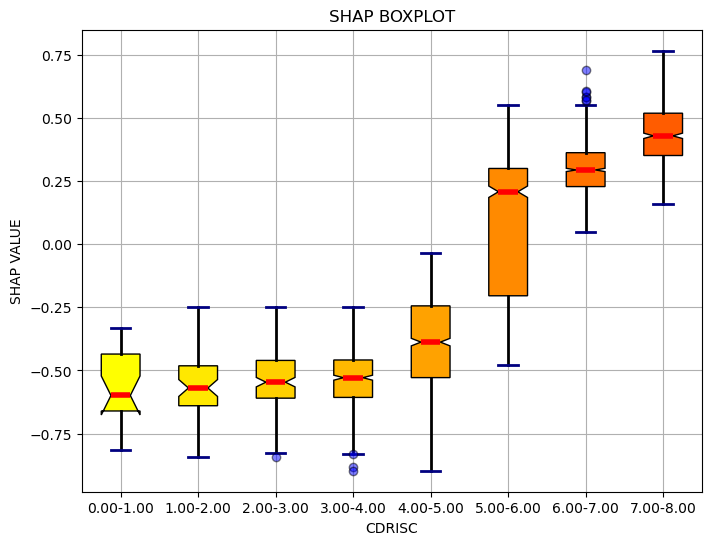

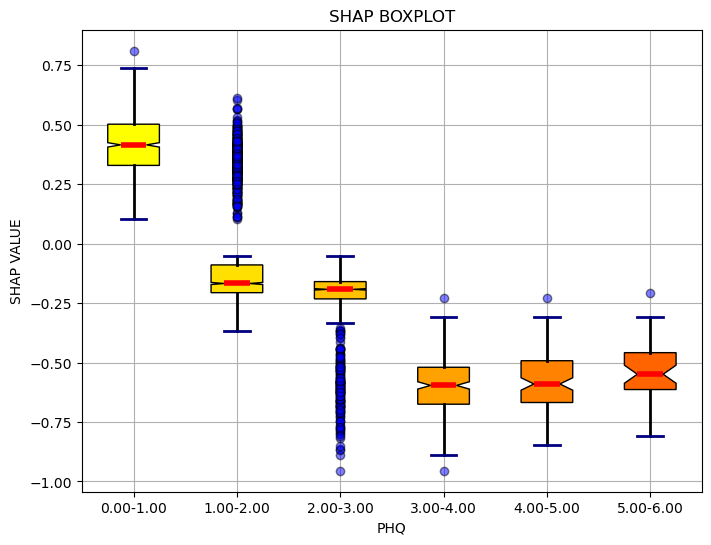

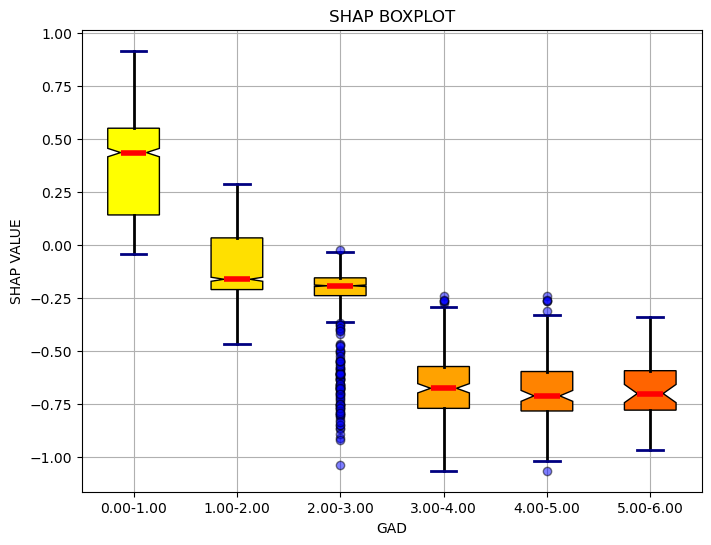

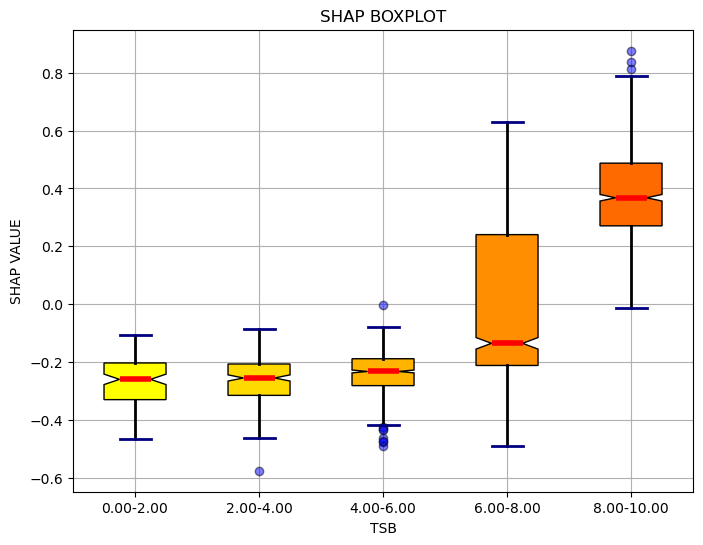

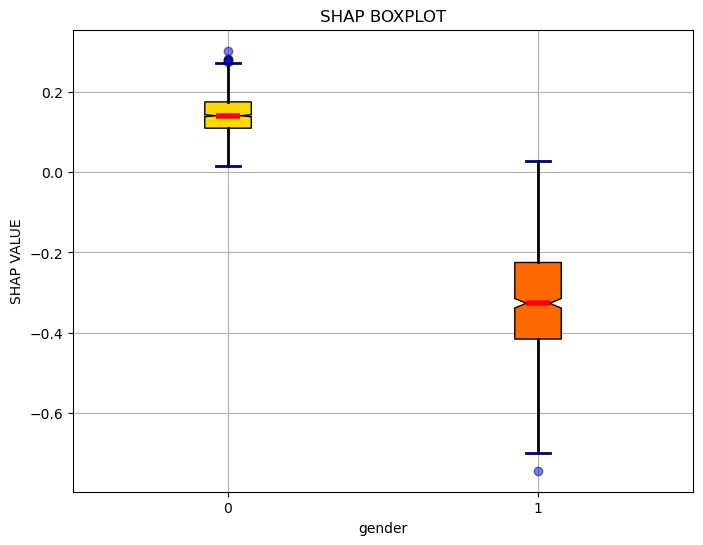

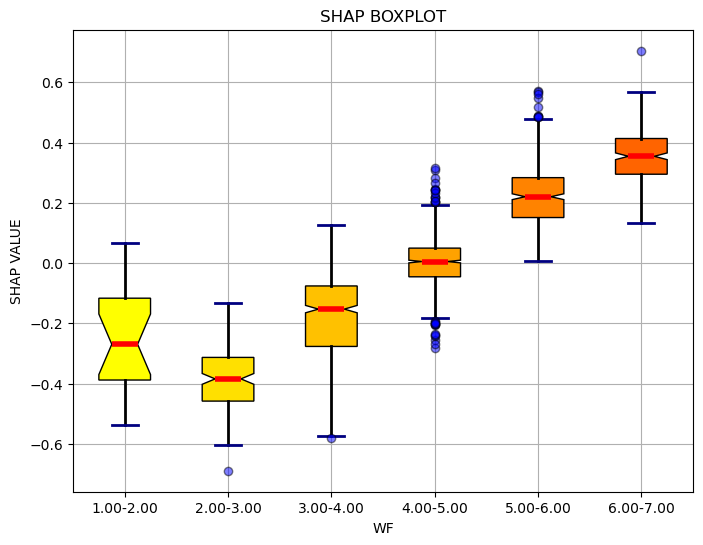

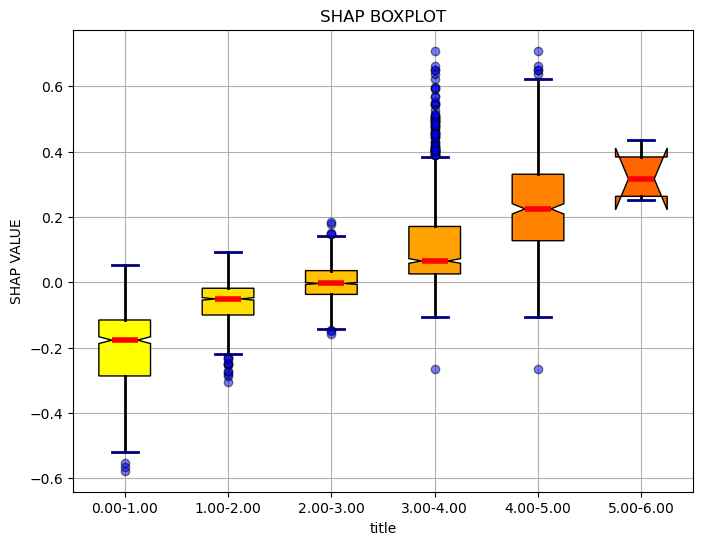

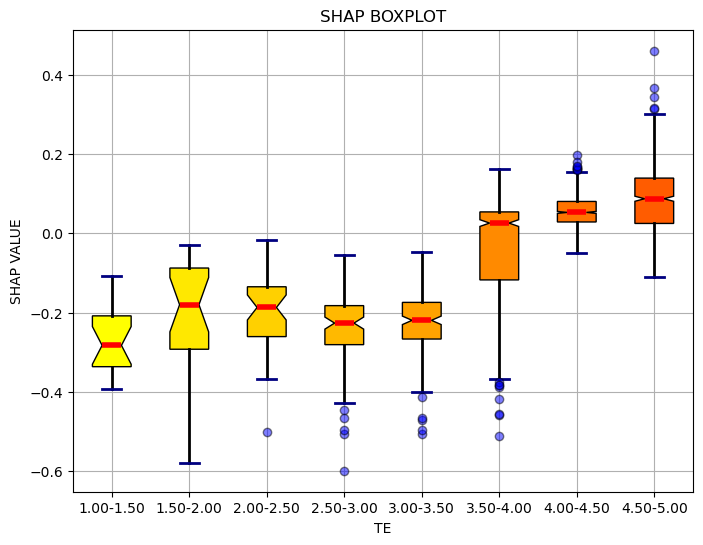

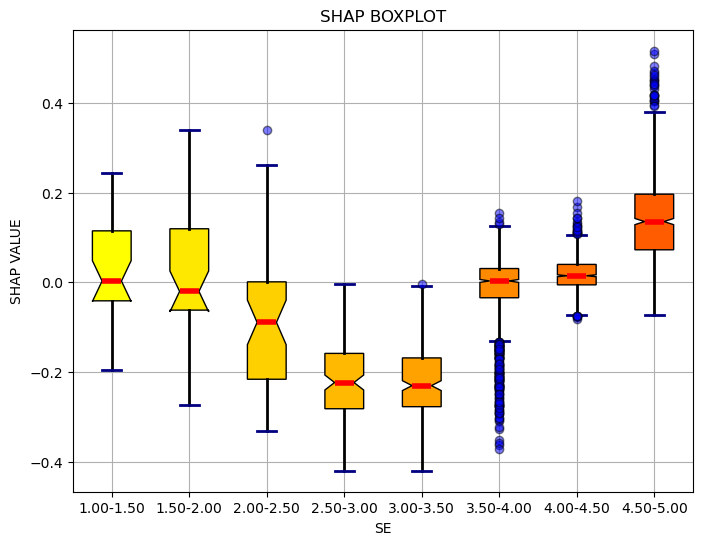

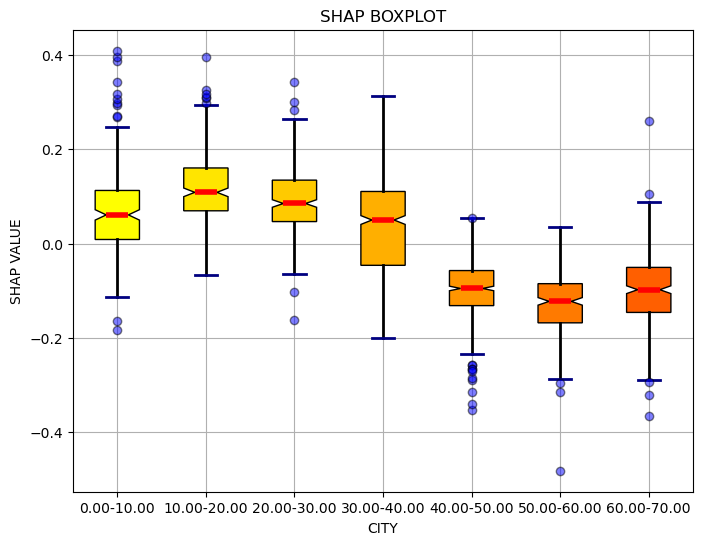

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import matplotlib.cm as cm  # 用于设置颜色映射
from matplotlib.colors import LinearSegmentedColormap  # 添加这一行
# 计算性能指标
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

# 模型训练与预测
def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

# 获取特征重要性
def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

# 机器学习函数
def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['high_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['high_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shap_values, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shap_values)
    print('重要特征:')
    print(top_features)
    print('重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shap_values, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

# 导入数据
df_path = r"C:\Users\29688\Desktop\T1教师_处理后.xlsx"
save_folder = r'C:\Users\29688\Desktop\study-2\pictures\high'  # 替换为你的保存路径
df = pd.read_excel(df_path)
top_n = 10

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu', 'height', 'weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan', 'BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work', 'mediation', 'mediationd',
             'sport', 'walk', 'sportd', 'walkd', 'TE', 'subject', 'SE', 'TSB', 'EC', 'WF'
            ]].astype(float)

# 因变量是 SWLS 列
df_tgt = df[['high_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

# 获取 SHAP 值
shap_values = result_map['LightGBM'][5]
x_test_value = result_map['LightGBM'][4]

# 需要绘制箱线图的特征和对应的边界
x_boundaries = {
    'CDRISC': np.linspace(0,8,9),
    'PHQ': np.linspace(0, 6, 7),
    'GAD': np.linspace(0, 6, 7),
    'TSB': np.linspace(0, 10,6),
    'gender': np.linspace(0,1,2),
    'WF': np.linspace(1,7,7),
    'title': np.linspace(0,6,7),
    'TE': np.linspace(1,5,9),
    'SE': np.linspace(1,5,9),
    'CITY': np.linspace(0,70,8)
}

# 创建自定义的亮黄色到深橙色渐变
colors = ["#FFFF00", "#FF4500"]  # 从亮黄色到深橙色
cmap = LinearSegmentedColormap.from_list("custom_yellow_orange", colors)

# 绘制SHAP值的箱线图，应用自定义的渐变颜色
for feature_name in x_boundaries.keys():
    feature_idx = np.where(np.array(df_src.columns) == feature_name)[0][0]
    features_shap = shap_values[:, feature_idx]    # 获取当前特征的 SHAP 值

    features_x_data = x_test_value[feature_name]  # 获取当前特征的测试数据
    features_boundaries = x_boundaries[feature_name]  # 获取当前特征的边界值

    if len(np.unique(features_x_data)) == 2:
        # 如果特征的取值只有两种，单独处理
        shap_values_0 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 0]
        shap_values_1 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 1]

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot([shap_values_0, shap_values_1], labels=['0', '1'], patch_artist=True, notch=True)

        # 使用自定义渐变颜色，亮黄色到深橙色
        colors = [cmap(0.2), cmap(0.8)]  # 亮黄色到深橙色
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        for flier in bpt['fliers']:
            flier.set(markerfacecolor='blue', marker='o', alpha=0.5)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

    else:
        # 否则按照区间划分进行处理
        box_data = []
        labels = []
        for j in range(len(features_boundaries) - 1):
            lower_bound = features_boundaries[j]
            upper_bound = features_boundaries[j + 1]
            subset_shap_values = [features_shap[k] for k, sample_value in enumerate(features_x_data)
                                  if lower_bound <= sample_value <= upper_bound]
            box_data.append(subset_shap_values)
            interval_label = f'{lower_bound:.2f}-{upper_bound:.2f}'
            labels.append(interval_label)

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot(box_data, labels=labels, patch_artist=True, notch=True)

        # 动态生成颜色，从亮黄色到深橙色渐变
        num_colors = len(box_data)
        colors = [cmap(i / num_colors) for i in range(num_colors)]  # 从亮黄色到深橙色渐变
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        for flier in bpt['fliers']:
            flier.set(markerfacecolor='blue', marker='o', alpha=0.5)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

plt.show()

训练集大小: 5737, 测试集大小: 2459
测试集中高二元变量分布: (2459, 43) (2459, 1)
Counter({0: 1625, 1: 834})
训练集中高二元变量分布: (5737, 43) (5737, 1)
Counter({0: 3836, 1: 1901})
开始训练LightGBM模型。。。
[LightGBM] [Info] Number of positive: 1901, number of negative: 3836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 5737, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331358 -> initscore=-0.702050
[LightGBM] [Info] Start training from score -0.702050


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


特征重要性:
[ 90 149  40  94  15 128 132  24  98  89  55   9  40   8  42  58 131  69
  74  77  91  35  24  47   0  29  41  32   0  69 130  54  72  69  77  60
  77  92  80  97 105 121 176]
排列索引:
[10 36 34  8 38 16  7 27 11 22  3  9 23 12  0 25 13 21 31 28 24  6 35  5
 33 29 26  4 14 39 32 30 37 41  1 15 19  2 40 17 42 20 18]
SHAP值:
[[ 0.05530977  0.13807773  0.14607286 ... -0.19827188 -0.21200475
   0.11033707]
 [-0.11444971  0.1379301   0.10096448 ... -0.25707104  0.01258706
   0.14815013]
 [ 0.04516138  0.29477132  0.06955604 ...  0.43899937  0.11404836
   0.22242196]
 ...
 [ 0.00508717 -0.05539699  0.13621197 ... -0.288867    0.25067706
  -0.3082596 ]
 [ 0.04854732  0.14795269  0.11801932 ...  0.38875387 -0.18361538
   0.1883136 ]
 [ 0.05797248 -0.1170827   0.17028849 ...  0.28930897  0.02282908
   0.25805891]]
重要特征:
['GAD' 'CDRISC' 'WF' 'PHQ' 'TSB' 'gender' 'UCLA' 'title' 'CITY' 'EC']
重要特征索引:
[18 20 42 17 40  2 19 15  1 41]
Accuracy: 0.7405, Precision: 0.6526, Recall: 0.5024, F1-score: 0

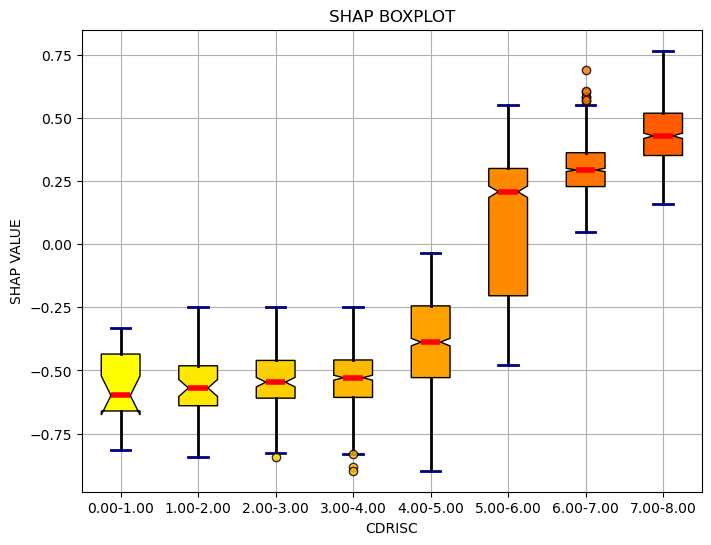

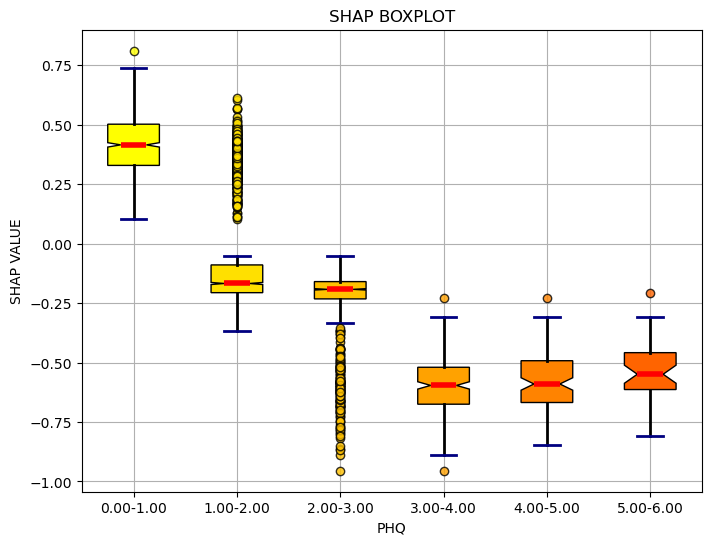

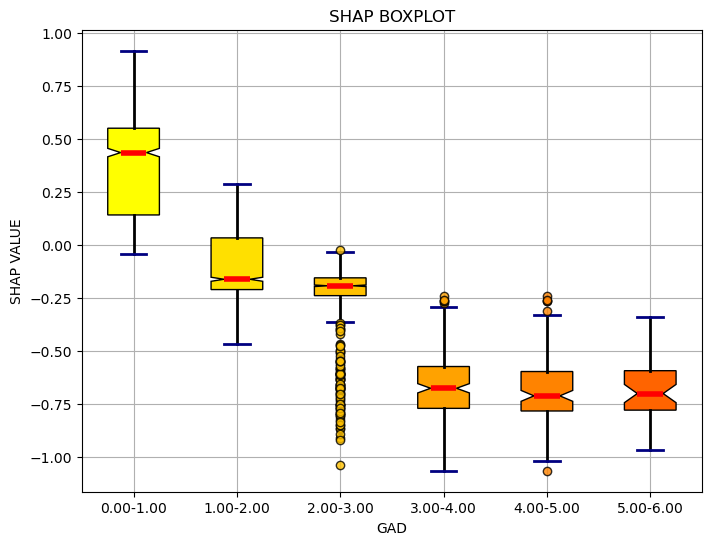

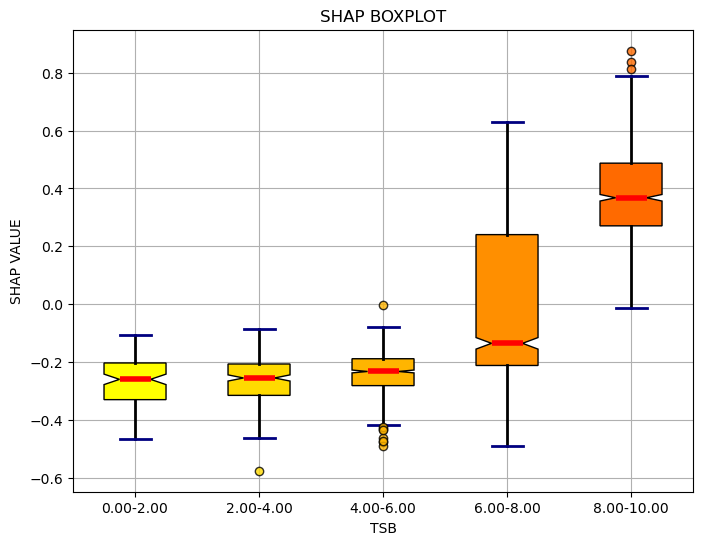

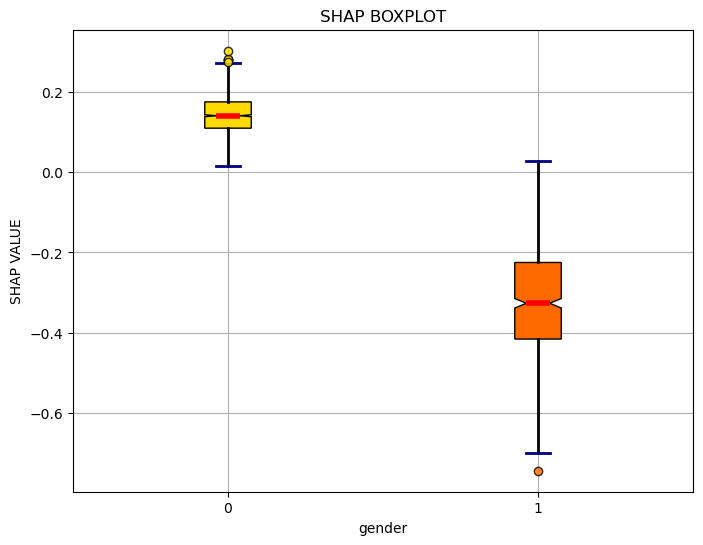

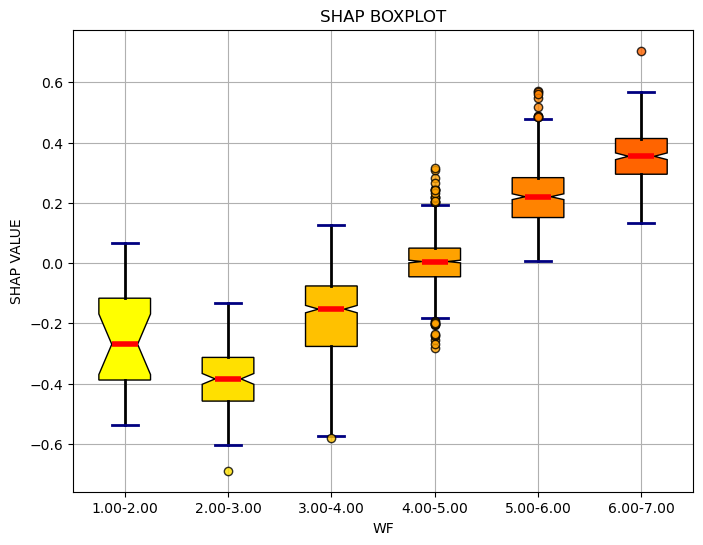

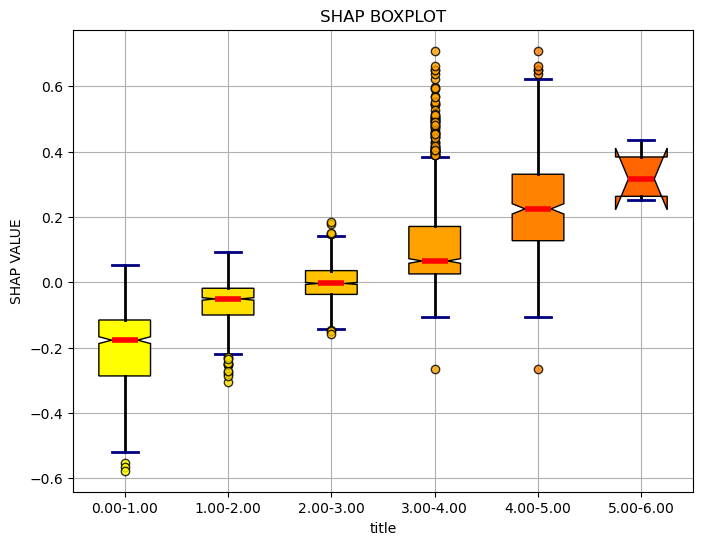

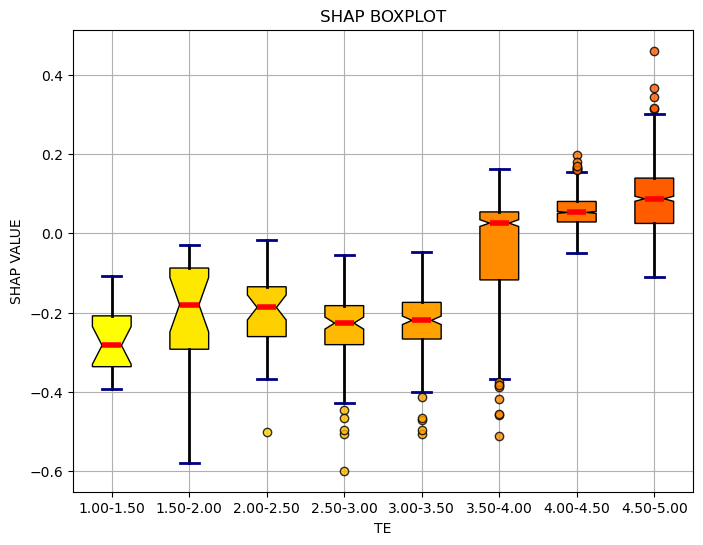

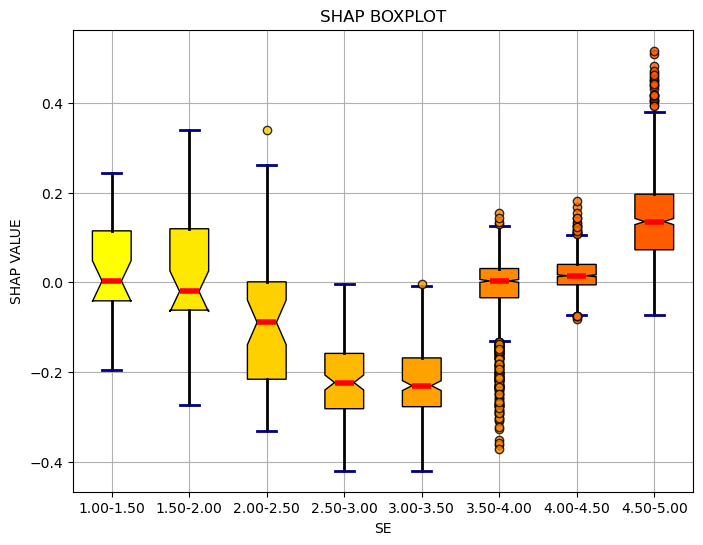

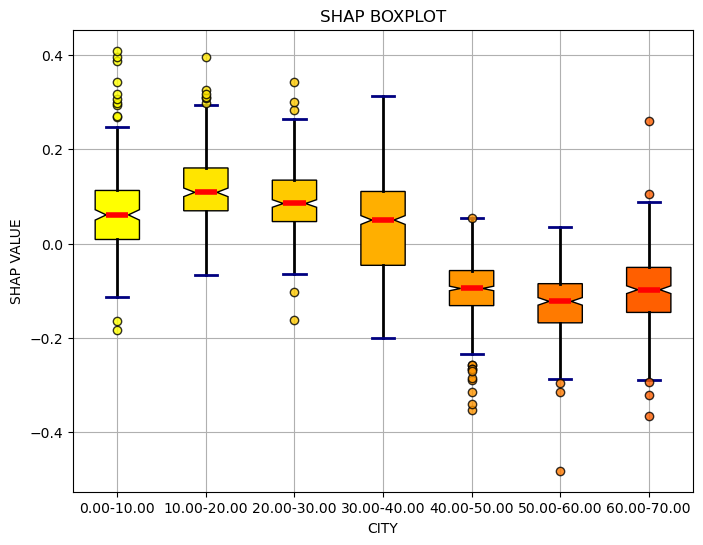

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import matplotlib.cm as cm  # 用于设置颜色映射
from matplotlib.colors import LinearSegmentedColormap  # 添加这一行

# 计算性能指标
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

# 模型训练与预测
def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

# 获取特征重要性
def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

# 机器学习函数
def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['high_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['high_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shap_values, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shap_values)
    print('重要特征:')
    print(top_features)
    print('重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shap_values, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

# 导入数据
df_path = r"C:\Users\29688\Desktop\T1教师_处理后.xlsx"
save_folder = r'C:\Users\29688\Desktop\study-2\pictures\high'  # 替换为你的保存路径
df = pd.read_excel(df_path)
top_n = 10

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu', 'height', 'weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan', 'BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work', 'mediation', 'mediationd',
             'sport', 'walk', 'sportd', 'walkd', 'TE', 'subject', 'SE', 'TSB', 'EC', 'WF'
            ]].astype(float)

# 因变量是 SWLS 列
df_tgt = df[['high_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

# 获取 SHAP 值
shap_values = result_map['LightGBM'][5]
x_test_value = result_map['LightGBM'][4]

# 需要绘制箱线图的特征和对应的边界
x_boundaries = {
    'CDRISC': np.linspace(0,8,9),
    'PHQ': np.linspace(0, 6, 7),
    'GAD': np.linspace(0, 6, 7),
    'TSB': np.linspace(0, 10,6),
    'gender': np.linspace(0,1,2),
    'WF': np.linspace(1,7,7),
    'title': np.linspace(0,6,7),
    'TE': np.linspace(1,5,9),
    'SE': np.linspace(1,5,9),
    'CITY': np.linspace(0,70,8)
}

# 创建自定义的亮黄色到深橙色渐变
colors =["#FFFF00", "#FF4500"] # 从亮黄色到深橙色
cmap = LinearSegmentedColormap.from_list("custom_yellow_orange", colors)

# 绘制SHAP值的箱线图，应用自定义的渐变颜色
for feature_name in x_boundaries.keys():
    feature_idx = np.where(np.array(df_src.columns) == feature_name)[0][0]
    features_shap = shap_values[:, feature_idx]    # 获取当前特征的 SHAP 值

    features_x_data = x_test_value[feature_name]  # 获取当前特征的测试数据
    features_boundaries = x_boundaries[feature_name]  # 获取当前特征的边界值

    if len(np.unique(features_x_data)) == 2:
        # 如果特征的取值只有两种，单独处理
        shap_values_0 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 0]
        shap_values_1 = [features_shap[k] for k, sample_value in enumerate(features_x_data) if sample_value == 1]

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot([shap_values_0, shap_values_1], labels=['0', '1'], patch_artist=True, notch=True)

        # 使用自定义渐变颜色，亮黄色到深橙色
        colors = [cmap(0.2), cmap(0.8)]  # 亮黄色到深橙色
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        
        # 动态设置异常值的颜色，使其与箱体颜色一致
        for flier, patch_color in zip(bpt['fliers'], colors):
            flier.set(markerfacecolor=patch_color, marker='o', alpha=0.8, markersize=6)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

    else:
        # 否则按照区间划分进行处理
        box_data = []
        labels = []
        for j in range(len(features_boundaries) - 1):
            lower_bound = features_boundaries[j]
            upper_bound = features_boundaries[j + 1]
            subset_shap_values = [features_shap[k] for k, sample_value in enumerate(features_x_data)
                                  if lower_bound <= sample_value <= upper_bound]
            box_data.append(subset_shap_values)
            interval_label = f'{lower_bound:.2f}-{upper_bound:.2f}'
            labels.append(interval_label)

        # 创建箱线图
        plt.figure(figsize=(8, 6))
        bpt = plt.boxplot(box_data, labels=labels, patch_artist=True, notch=True)

        # 动态生成颜色，从亮黄色到深橙色渐变
        num_colors = len(box_data)
        colors = [cmap(i / num_colors) for i in range(num_colors)]  # 从亮黄色到深橙色渐变
        for patch, color in zip(bpt['boxes'], colors):
            patch.set_facecolor(color)

        # 设置胡须、箱体、异常值、中位数的样式
        for whisker in bpt['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bpt['caps']:
            cap.set(color='navy', linewidth=2)
        for median in bpt['medians']:
            median.set(color='red', linewidth=4)
        
        # 动态设置异常值的颜色，使其与箱体颜色一致
        for flier, patch_color in zip(bpt['fliers'], colors):
            flier.set(markerfacecolor=patch_color, marker='o', alpha=0.8, markersize=6)

        # X/Y轴标签和网格
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.grid(True)
        plt.title(f'SHAP BOXPLOT')
        file_path = os.path.join(save_folder, feature_name + '_boxplot.png')
        plt.savefig(file_path)

plt.show()
